In [94]:
import os
import json
from collections import deque
import re
from PIL import Image
import torch
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [2]:
coco_object_categories = []
coco_classes = {}
target_classes = ['__bgr__', 'person', 'car']


with open('./mscoco_labels.txt', 'r') as f:
    for id, category in enumerate(f.readlines()):
        category = re.sub('[\d]+\W+','', category.rstrip())         
        coco_object_categories.append(category)
        coco_classes[category] = id

In [203]:
class MSCOCO(data.Dataset):
    
    def __init__(self, root_path, list_of_classes, target_classes, annotation_json_path=None):
        
        self.root_path = root_path
        self.data_path = os.path.join(self.root_path, 'train2017')
        self.annotation_path = os.path.join(self.root_path, 'annotations_trainval2017/annotations')
        self.list_of_classes = list_of_classes
        self.target_classes = target_classes
        
        
        self._annotation_helper()
        if annotation_json_path:
            self.annotations = json.load(open(annotation_json_path))
        else:
            self.annotations = self.get_annotations()
        self.imgs = self.get_imgs()
        
        
    def _annotation_helper(self):
            
        self.class_to_idx = {}
        self.idx_to_class = {}
        for cls in self.target_classes:
            self.class_to_idx[cls] = self.list_of_classes[cls]
            self.idx_to_class[self.list_of_classes[cls]] = cls
    
    def get_imgs(self):
        imgs = []
        for anno in self.annotations:
            file_name = str(anno)
            file_name = file_name.zfill(12)+'.jpg'
            imgs.append(file_name)
        
        return imgs
    
    def load_img(self, idx, transform=True):
        img = Image.open(os.path.join(self.data_path, self.imgs[idx]))
        if transform:
            img = self.image_transform(img)    
        return img
    
    def image_transform(self, img):
        t_ = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.407, 0.457, 0.485],
                                 std = [0.229,0.224,0.225])
        ])
        img = t_(img)
        return img
    
    def get_annotations(self):
        annotations = {}
        
        data = json.load(open(os.path.join(self.annotation_path, 'instances_train2017.json')))
        # create the dic
        images_data = deque(data['images'])
        
        annotations = {}
        for img in images_data:
            annotations[str(img['id'])] = []
        
        annotations_data = deque(data['annotations'])
        
        for ann in annotations_data:
            if ann['category_id'] in self.idx_to_class:
                annotations[str(ann['image_id'])].append((ann['bbox'], ann['category_id']))
        
        for anno in annotations.copy():
            if len(annotations[anno]) == 0 :
                annotations.pop(anno)
        
        return annotations
    
    
    def get_bboxes(self, idx):
        file_name = self.imgs[idx].split('.')[0].lstrip('0')
        label = {}
        classes = []
        bboxes = []
        for annotation in self.annotations[file_name]:
            box_coco = annotation[0]
            box = [box_coco[0], box_coco[1], box_coco[0]+box_coco[2], box_coco[1]+box_coco[3]]
            bboxes.append(box)
            classes.append(annotation[1])
        
        label['labels'] = torch.tensor(classes)
        label['boxes'] = torch.tensor(bboxes)
        
        return label
    
    
    def display_img(self, idx):
        img = self.load_img(idx, False)
        label = self.get_bboxes(idx)
        classes = [self.idx_to_class[cls] for cls in label['labels'].numpy()]
        bboxes = label['boxes']
        fig, ax = plt.subplots()
        ax.imshow(img)
        for i in range(len(classes)):
            bbox = bboxes[i]
        #for bbox in bboxes:
            rect = patches.Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],edgecolor='r', facecolor="none")
            ax.add_patch(rect)
            print(classes[i])
            
        plt.axis('off')
        plt.show()
        
                        
    def __len__(self):
        return len(self.imgs)
    
    
    def __getitem__(self, idx):        
        X = self.load_img(idx)
        y = self.get_bboxes(idx)
        
        return idx, X, y

In [204]:
root_path = '../../../Datasets/MS COCO'

In [205]:
coco_interface = MSCOCO(root_path, coco_classes, target_classes, 'annotation_data.json')

person
person


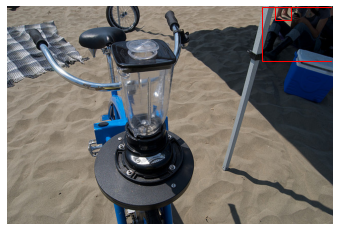

In [220]:
randindx = random.randint(0, len(coco_interface))
coco_interface.display_img(randindx)